# Topic : Employee Leave Prediction

# STAT4011 Group 8 Project 2

### Library Installation and Import

In [ ]:
# Install the basic library required
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn

# Install the library required for model building and evaluation
!pip install lightgbm
!pip install hyperopt
!pip install xgboost
!pip install pydotplus


In [1]:
# Import the basic library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import the library for data preprocessing
import scipy as stats
from scipy.stats import chi2
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Import the library for model building and evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from six import StringIO
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import lightgbm as lgbm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from warnings import simplefilter
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

### Import Data and Overview

In [2]:
# Read the csv file using pandas to a dataframe.
df = pd.read_csv('Employee.csv')
# Review the first 5 data for overview
df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


In [3]:
# Check the info of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
 8   LeaveOrNot                 4653 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 327.3+ KB


## Section: Data Visualization
In this section, we are trying to see is there any relationship between the input in the data set. The following graphs will be generated:
1. Box plot for Age distribution
2. Pie Chart for Y label Leave or not
3. Histogram for distribution of age and work experience with KDE
4. Line plot for average of work experience per age
5. Stacked bar plot for payment tier per city
6. Heatmap for total sum of people per city by joining years
7. Correlation matrix for continuous variables
8. Violin plot
9. Barplot for all Features

**Person-in-charge:** Cheong Euikyun, Lui Chak Sum

In [4]:
# Store data with numerical values
num_data = df.iloc[:,[1,4,7]]
num_data.head()

,JoiningYear,Age,ExperienceInCurrentDomain
0,2017,34,0
1,2013,28,3
2,2014,38,2
3,2016,27,5
4,2017,24,2


### 1. Box plot for Age distribution

<AxesSubplot:xlabel='Age'>

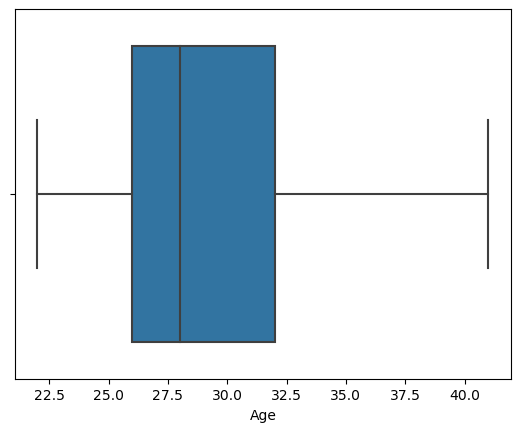

In [5]:
sns.boxplot(x=df['Age'])

### 2. Pie Chart for Y label Leave or not

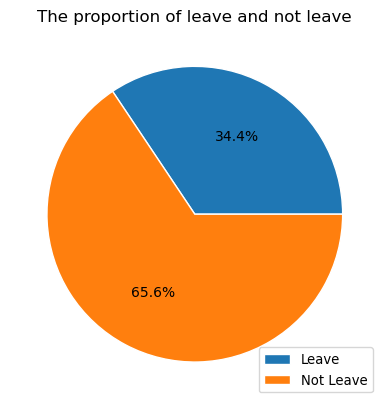

In [6]:
# Variables for generating the graph
labels = ["Leave", "Not Leave"]
value = [df["LeaveOrNot"].value_counts()[1], df["LeaveOrNot"].value_counts()[0]]

# Generate pie chart
fig, ax = plt.subplots()
ax.pie(value, autopct = '%1.1f%%', wedgeprops = {"linewidth": 1, "edgecolor": "white"})

# Adding legend
plt.legend(["Leave", "Not Leave"], fontsize=9.5, loc="lower right")

# Show the chart with title
ax.set_title("The proportion of leave and not leave")
plt.show()

### 3. Histogram for distribution of age and work experience with KDE

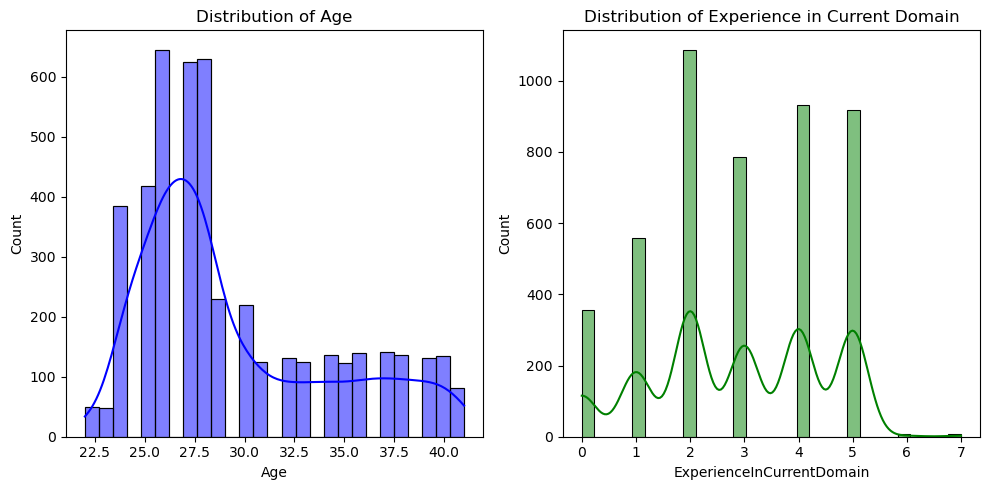

In [7]:
plt.figure(figsize=(10, 5))

# Histogram for Age
plt.subplot(1, 2, 1)
sns.histplot(df['Age'], kde=True, color='blue')
plt.title('Distribution of Age')

# Histogram for ExperienceInCurrentDomain
plt.subplot(1, 2, 2)
sns.histplot(df['ExperienceInCurrentDomain'], kde=True, color='green')
plt.title('Distribution of Experience in Current Domain')

plt.tight_layout()
plt.show()

### 4. Line plot for average of work experience per age

<AxesSubplot:xlabel='Age'>

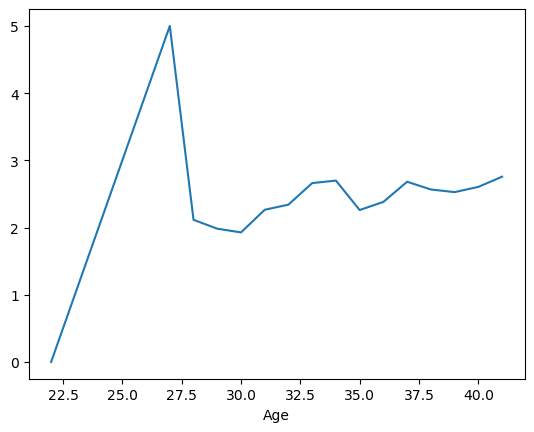

In [8]:
# Distribution of Age X ExperienceInCurrentDomain
df.groupby('Age')['ExperienceInCurrentDomain'].mean().plot.line()

# Higher Age doesn't illustrate the longer experience in current domain.

### 5. Stacked bar plot for payment tier per city

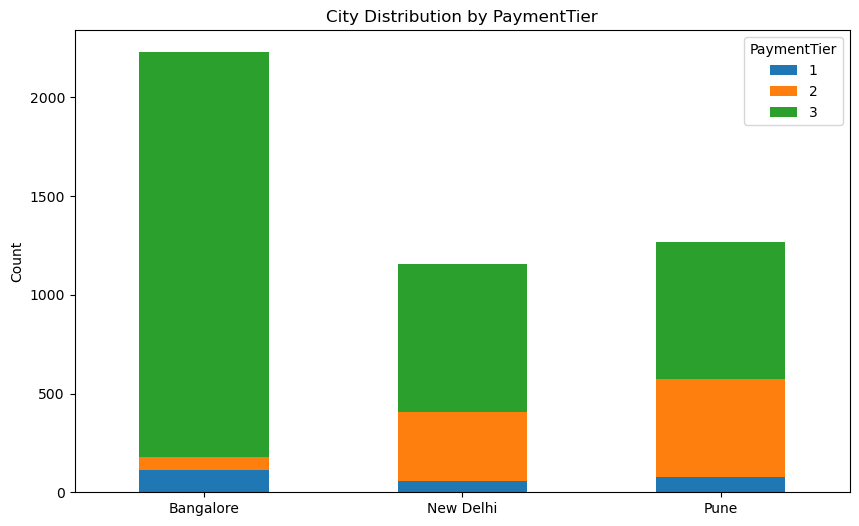

In [9]:
# We need to create a count of occurrences for each group to plot
df_stack = df.groupby(['City', 'PaymentTier']).size().unstack()

# Plotting the stacked bar chart
df_stack.plot(kind='bar', stacked=True, figsize=(10, 6), rot=0)
plt.title('City Distribution by PaymentTier')
plt.xlabel('')
plt.ylabel('Count')
plt.legend(title='PaymentTier')
plt.show()

### 6. Heatmap for total sum of people per city by joining years

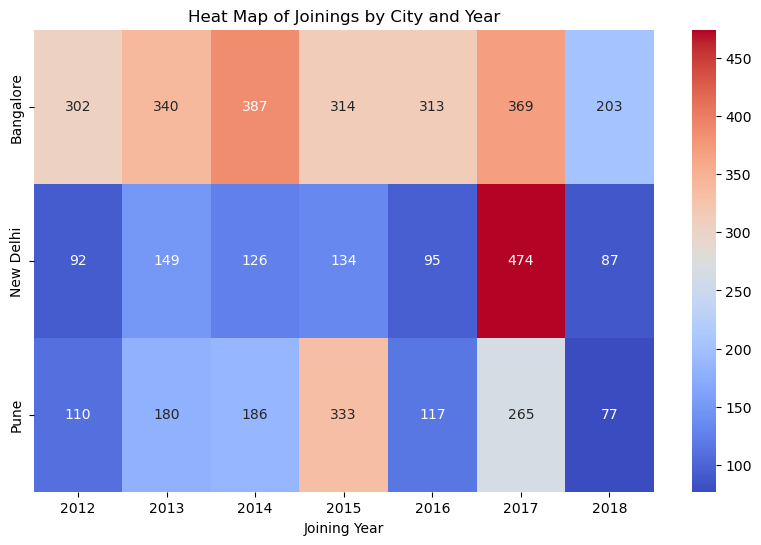

In [10]:
grouped_data = df.groupby(['City', 'JoiningYear']).size().reset_index(name='Joinings')

# Pivot the grouped data to create a matrix suitable for a heatmap
pivot_table = grouped_data.pivot('City', 'JoiningYear', 'Joinings')

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt=".0f")  # Using ".0f" for integer format
plt.title('Heat Map of Joinings by City and Year')
plt.xlabel('Joining Year')
plt.ylabel('')
plt.show()

### 7. Correlation matrix for numerical variables

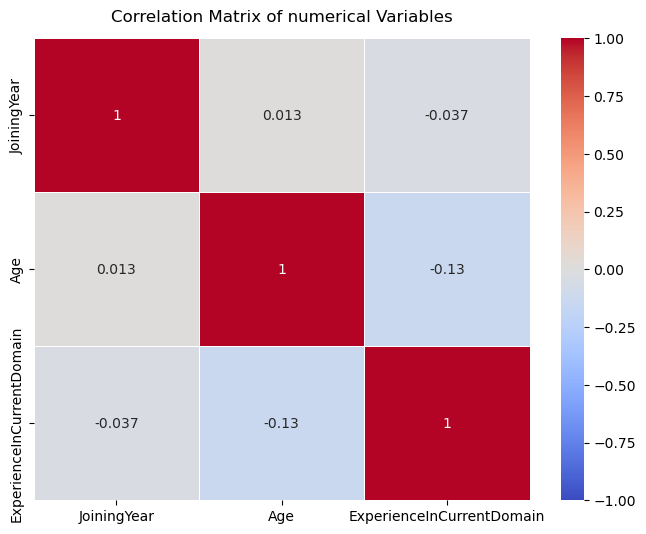

In [11]:
corr_matrix = df[['JoiningYear', 'Age', 'ExperienceInCurrentDomain']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Matrix of numerical Variables', fontdict={'fontsize':12}, pad=12)
plt.show()

### 8. Violin plot

Text(0.5, 0, '')

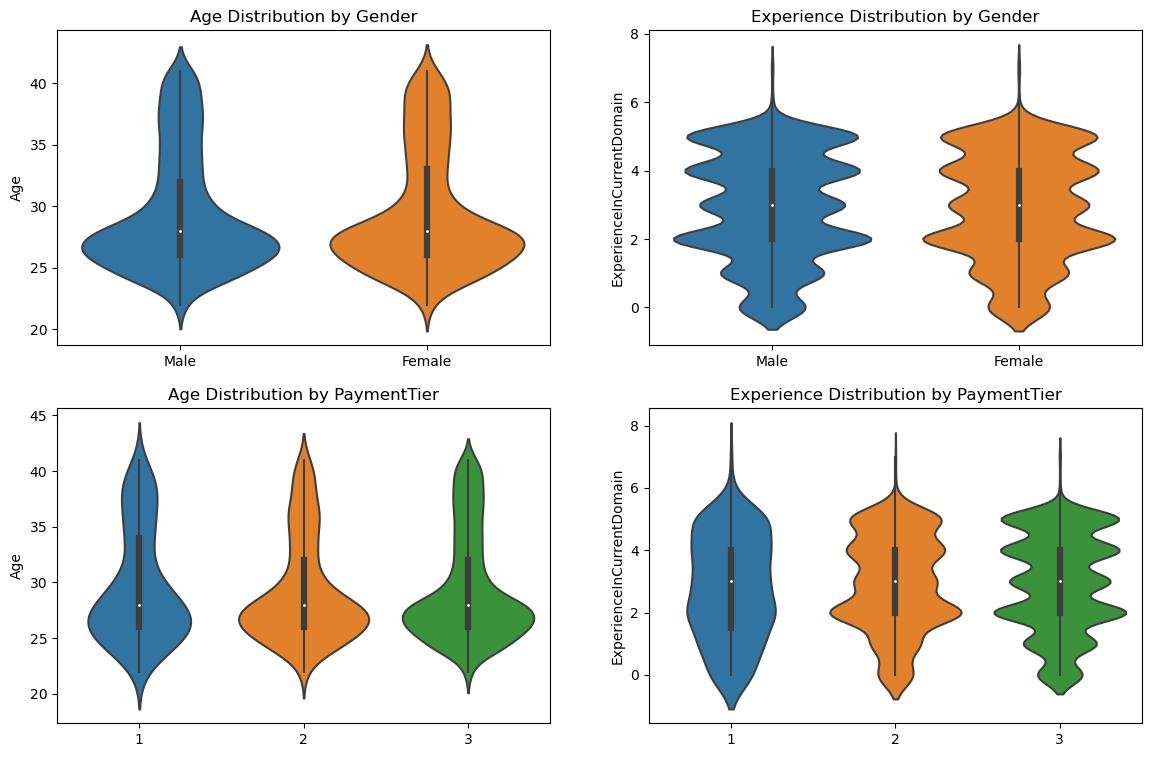

In [12]:
df_violin = df.copy()

# Plotting violin plots for 'Age' and 'ExperienceInCurrentDomain' by 'Gender' and 'PaymentTier'
plt.figure(figsize=(14, 9))

# Violin plot for 'Age' by 'Gender'
plt.subplot(2, 2, 1)
sns.violinplot(x='Gender', y='Age', data=df_violin)
plt.title('Age Distribution by Gender')
plt.xlabel('')


# Violin plot for 'ExperienceInCurrentDomain' by 'Gender'
plt.subplot(2, 2, 2)
sns.violinplot(x='Gender', y='ExperienceInCurrentDomain', data=df_violin)
plt.title('Experience Distribution by Gender')
plt.xlabel('')


# Violin plot for 'Age' by 'PaymentTier'
plt.subplot(2, 2, 3)
sns.violinplot(x='PaymentTier', y='Age', data=df_violin, order=[1, 2, 3])
plt.title('Age Distribution by PaymentTier')
plt.xlabel('')


# Violin plot for 'ExperienceInCurrentDomain' by 'PaymentTier'
plt.subplot(2, 2, 4)
sns.violinplot(x='PaymentTier', y='ExperienceInCurrentDomain', data=df_violin, order=[1, 2, 3])
plt.title('Experience Distribution by PaymentTier')
plt.xlabel('')


### 9. Barplot for all Features

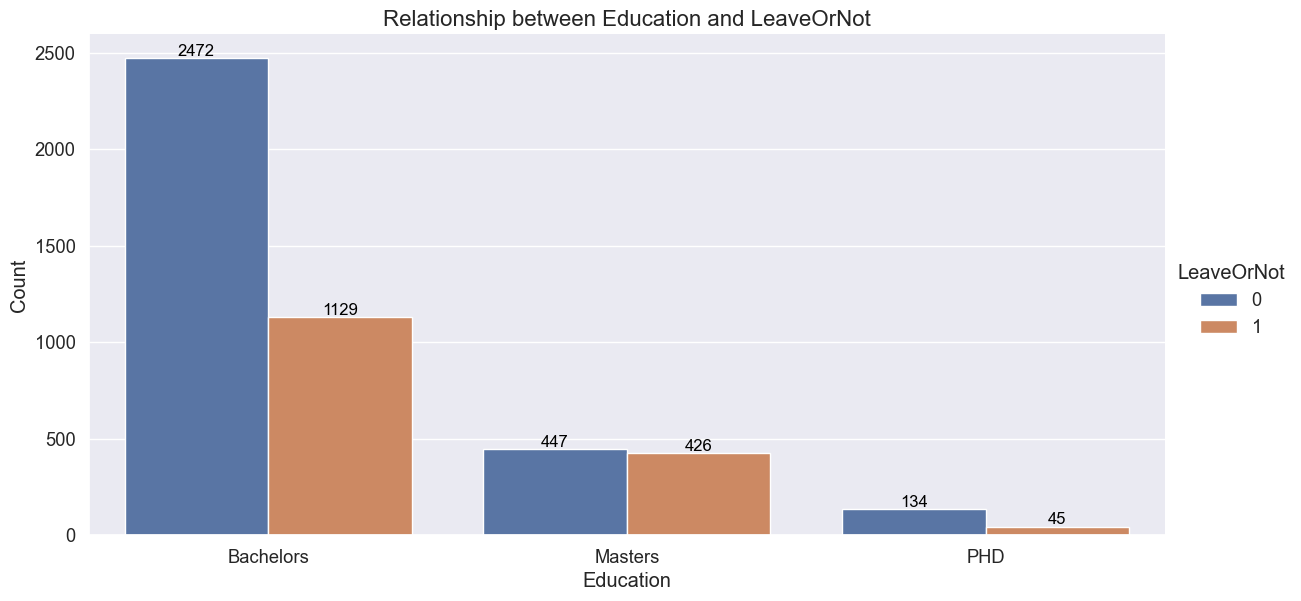

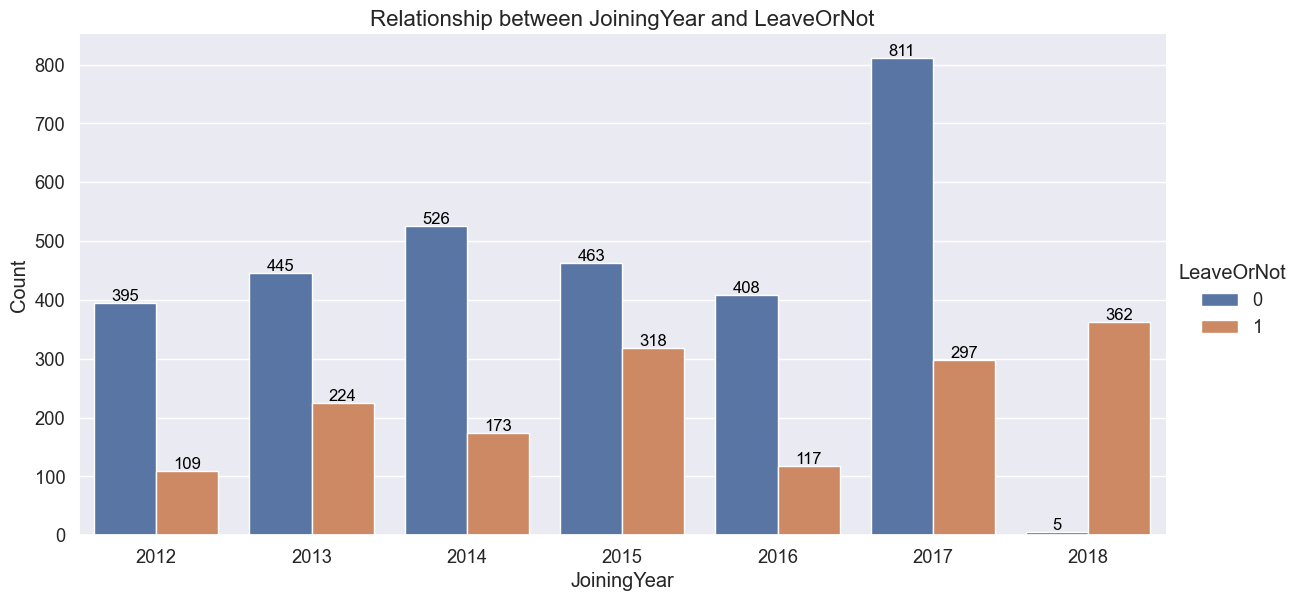

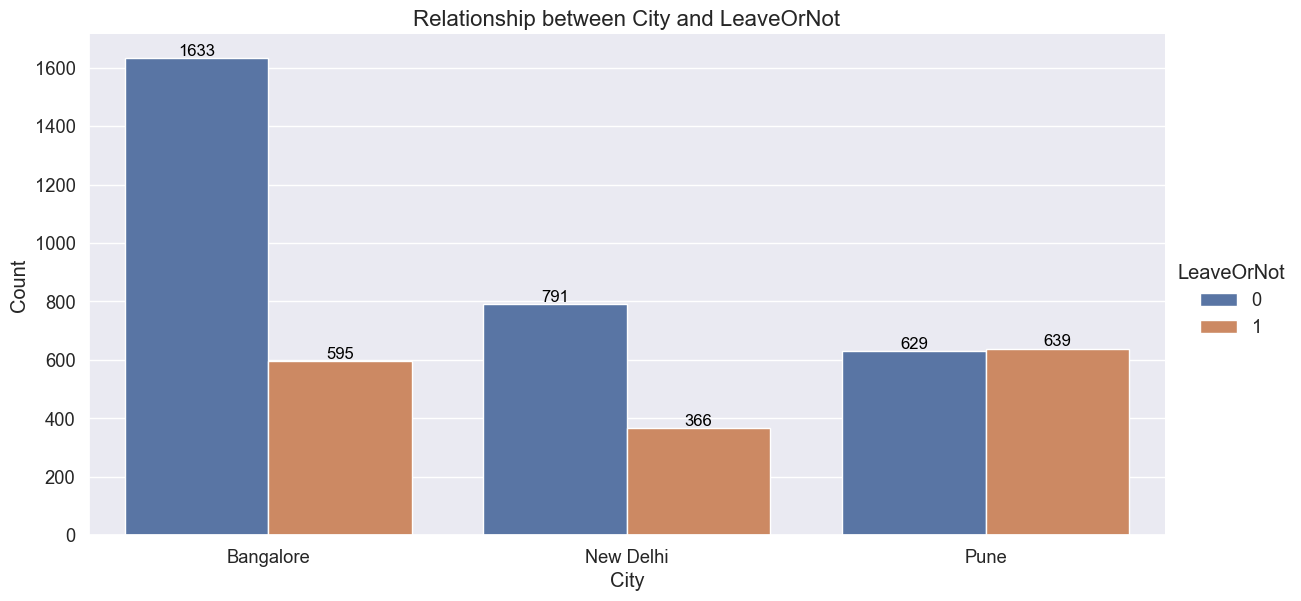

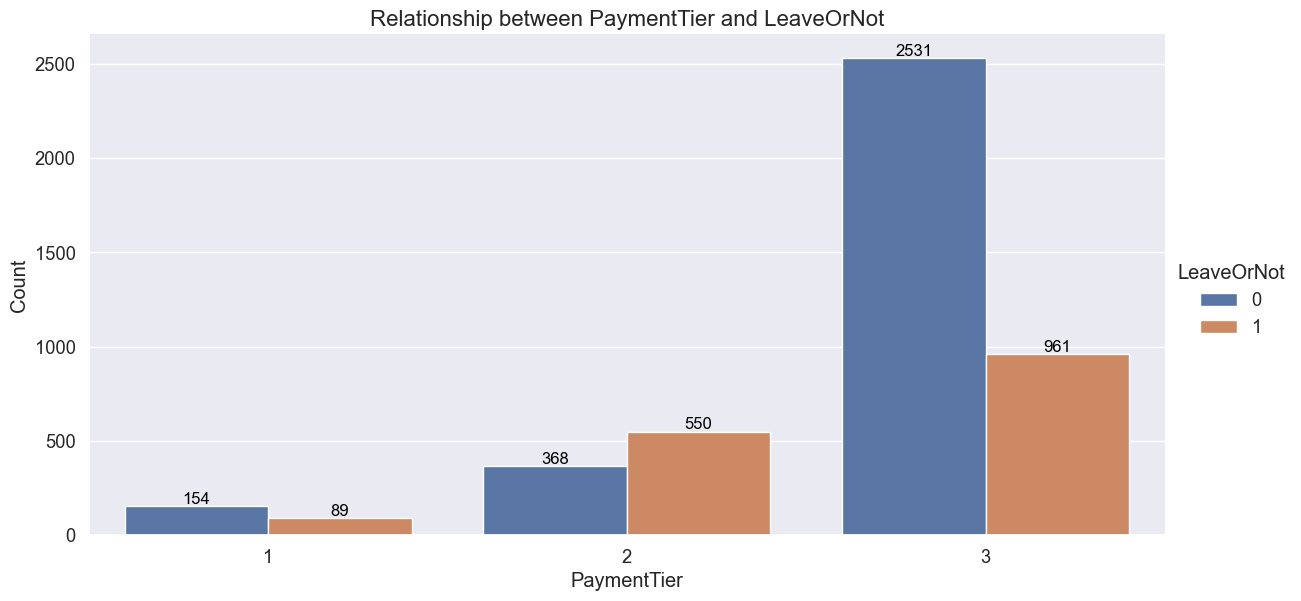

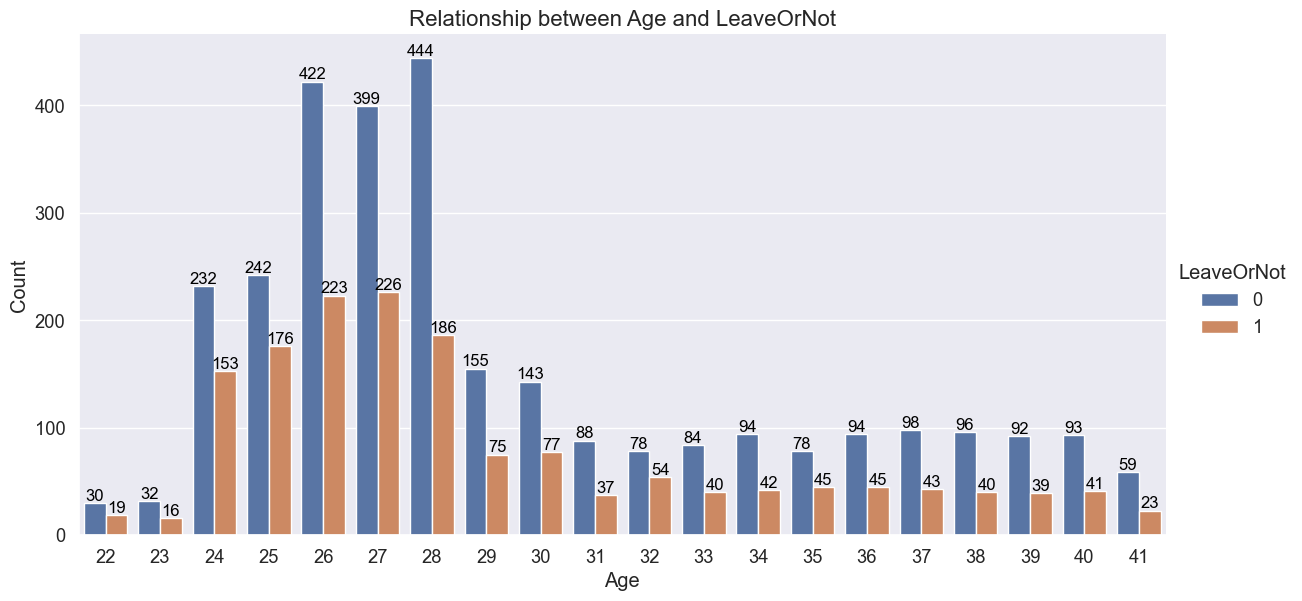

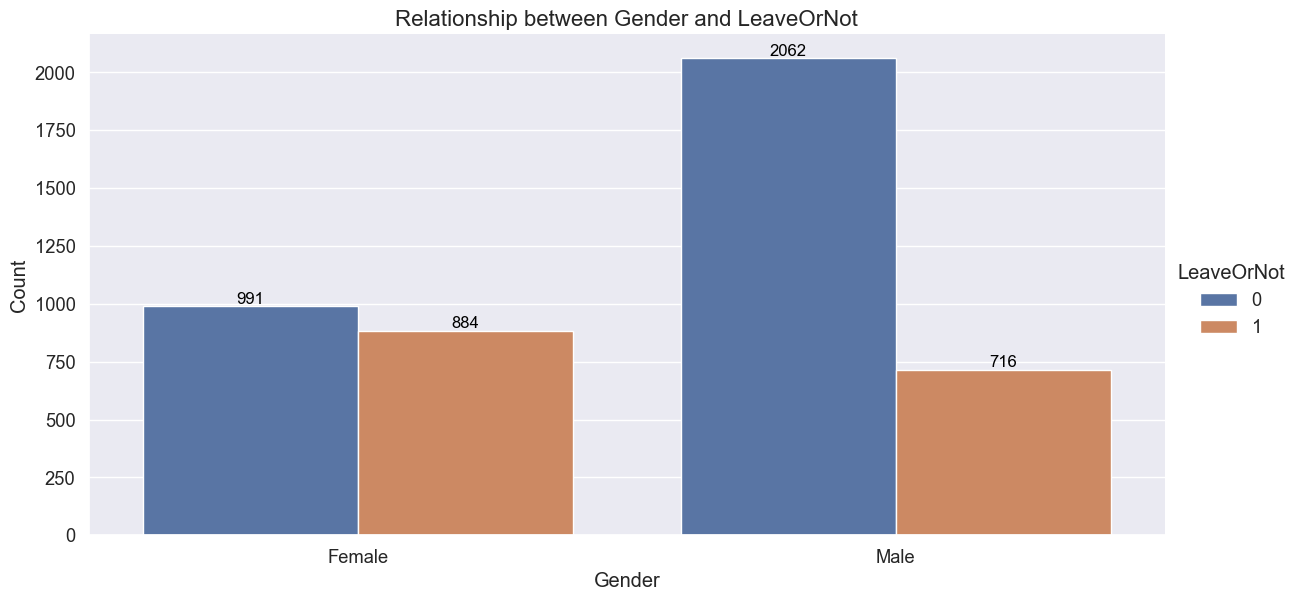

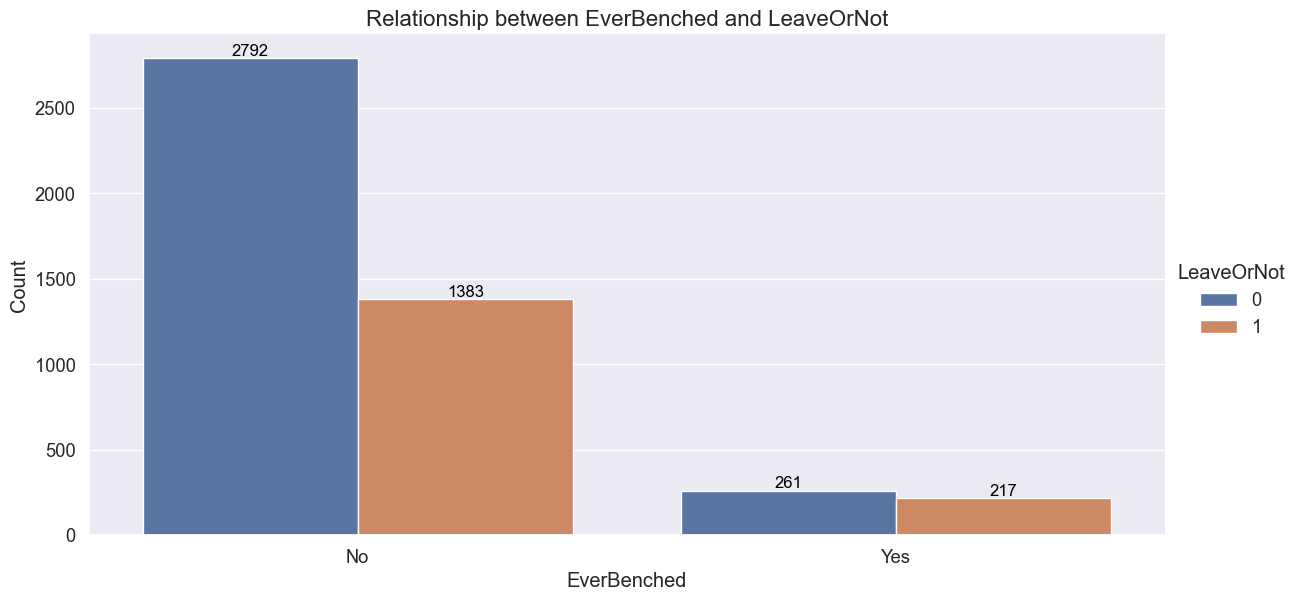

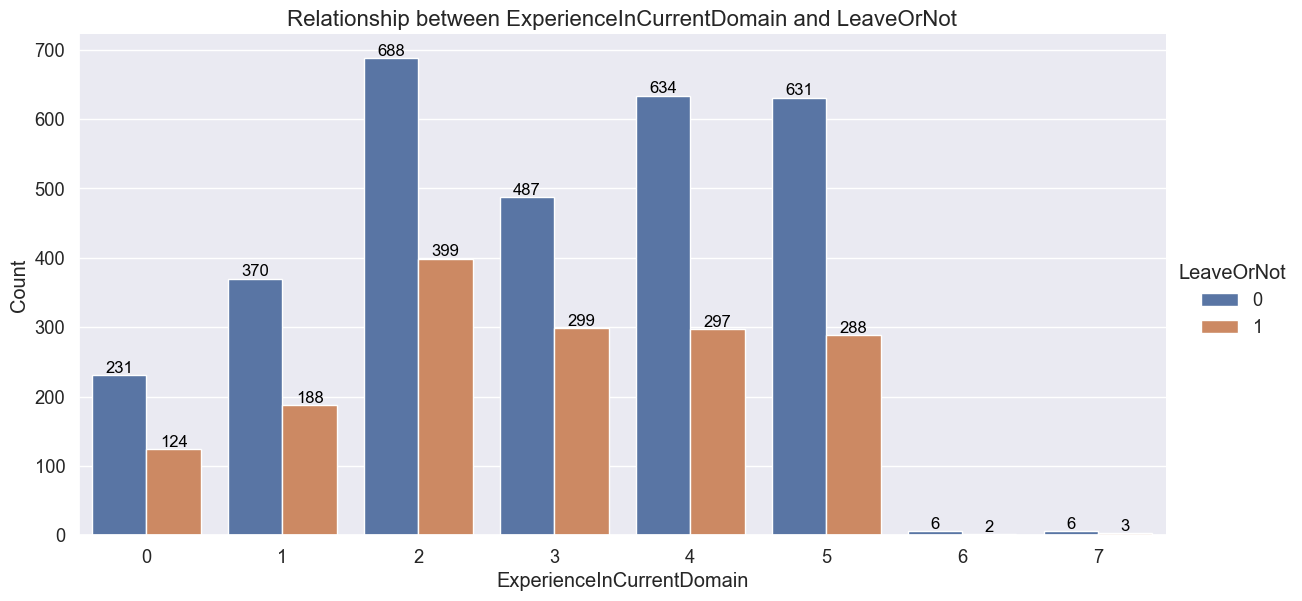

In [13]:
# Define the list of categorical columns we want to visualize
all_columns = ['Education', 'JoiningYear',	'City',	'PaymentTier', 'Age', 'Gender', 'EverBenched', 'ExperienceInCurrentDomain']

# Customize the font size
sns.set(font_scale=1.2)

# Define the legend labels
legend_labels = {
    '0': 'Not Leave',
    '1': 'Leave'
}

# Iterate over each categorical column
for col in all_columns:
    # Group by the current column and 'Churn' and calculate counts
    df_group = df.groupby(col)['LeaveOrNot'].value_counts().rename('Count').reset_index()

    # Create a bar plot for the current column
    plot = sns.catplot(x=col, y='Count', hue='LeaveOrNot', kind='bar', data=df_group, height=6, aspect=12/6)

    # Add count labels on top of the bars
    for p in plot.ax.patches:
        plot.ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

    # Set the title for the current plot
    plt.title(f'Relationship between {col} and LeaveOrNot', fontdict={'fontsize': 16})

    # Show the plot
    plt.show()

## Section: Data Cleansing and Preprocessing
In this section, we are going to clean and preprocess our raw dataset before we can draw some insights from the cleaned data, as well as fit the processed data into our model candidates. We are going to do as follows:
1. Check and handle for any missing value, incorrectly formatted and duplicate data
2. Check if outliers exist
3. Encoding
4. Splitting Train and Test data for one-hot encoding and label encoding
**Person-in-charge:** Ho Tsz Hin, Cheong Euikyun

### 1. Check and handle any missing value

In [14]:
df.isnull().sum()

Education                    0
JoiningYear                  0
City                         0
PaymentTier                  0
Age                          0
Gender                       0
EverBenched                  0
ExperienceInCurrentDomain    0
LeaveOrNot                   0
dtype: int64

 It was determined that the dataset contains no missing values.

### 2. Remove outliers

In [15]:
# Get the Descriptive statistics
df.describe()

,JoiningYear,PaymentTier,Age,ExperienceInCurrentDomain,LeaveOrNot
count,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000
mean,2015.062970,2.698259,29.393295,2.905652,0.343864
std,1.863377,0.561435,4.826087,1.558240,0.475047
min,2012.000000,1.000000,22.000000,0.000000,0.000000
25%,2013.000000,3.000000,26.000000,2.000000,0.000000
50%,2015.000000,3.000000,28.000000,3.000000,0.000000
75%,2017.000000,3.000000,32.000000,4.000000,1.000000
max,2018.000000,3.000000,41.000000,7.000000,1.000000


According to the result from data visualization and descriptive statistics, no outlier is detected.

In [16]:
# Check the dimension of the dataset
df.shape

(4653, 9)

### 3. Encoding

In this project, we will use One-Hot Encoding.
One-Hot Encoding has the advantage that the result is binary rather than ordinal and that everything sits in an orthogonal vector space.
The disadvantage is that for high cardinality, the feature space can really blow up quickly and we start fighting with the curse of dimensionality. In these cases, we typically employ one-hot-encoding only since the new number of variables are reasonably suitable.

In [17]:
df.columns

Index(['Education', 'JoiningYear', 'City', 'PaymentTier', 'Age', 'Gender',
       'EverBenched', 'ExperienceInCurrentDomain', 'LeaveOrNot'],
      dtype='object')

In [18]:
df_ohe = pd.get_dummies(df,columns=['Education', 'JoiningYear', 'City', 'PaymentTier', 'Gender', 'EverBenched', 'ExperienceInCurrentDomain'],drop_first=False)

In [19]:
df_ohe.head()

,Age,LeaveOrNot,Education_Bachelors,Education_Masters,Education_PHD,JoiningYear_2012,JoiningYear_2013,JoiningYear_2014,JoiningYear_2015,JoiningYear_2016,...,EverBenched_No,EverBenched_Yes,ExperienceInCurrentDomain_0,ExperienceInCurrentDomain_1,ExperienceInCurrentDomain_2,ExperienceInCurrentDomain_3,ExperienceInCurrentDomain_4,ExperienceInCurrentDomain_5,ExperienceInCurrentDomain_6,ExperienceInCurrentDomain_7
0,34,0,1,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
1,28,1,1,0,0,0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0
2,38,0,1,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
3,27,1,0,1,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
4,24,1,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


### 4. Splitting Train and Test data for one-hot encoding and label encoding

In [20]:
# Create Train & Test Data
X_train, X_test, y_train, y_test = train_test_split(df_ohe.drop(columns=['LeaveOrNot']), df_ohe['LeaveOrNot'].values, test_size=0.2, random_state=42)


## Section: Model Building
In this section, we are trying to train different models to predict the loan_status output. The following models will be generated:
1. Decision Tree
2. Light Gradient Boosting Machine
3. Bagging
4. Random Forest

E1. XGBoost and E2. K-NN Algorithm are also generated but due to spacing we will not include them in the report.

**Person-in-charge:** Chau Ka Yan(1), Lui Chak Sum(2), Wong Tuen Hong(3), Cheong Euikyun(4), Ho Tsz Hin(E1), Li Shengwei(E2)

In [21]:
# Model Evaluation Function
def model_performance(y_test, y_pred) :
    #Show metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))
    FPR = (fp/(fp+tn))

    print(f'Accuracy :{Accuracy}')
    print(f'Precision :{Precision}')
    print(f'Recall :{Recall}')
    print(f'F1_score :{F1_score}')
    print(f'FPR :{FPR}')

    return Accuracy, Precision, Recall, F1_score, FPR

### 1. Decision Tree

Without hyperparameter tuning

In [22]:
# Build a Decision Tree Classifier
DecisionTree = DecisionTreeClassifier(criterion="entropy",random_state=0)

# Fitting the model
DecisionTree.fit(X_train, y_train)

# Predict leave or not
DecisionTree_pred = DecisionTree.predict(X_test)

# Evaluate the model
dt_Accuracy, dt_Precision, dt_Recall, dt_F1_score ,dt_FPR = model_performance(y_test, DecisionTree_pred)

Accuracy :0.8399570354457573
Precision :0.7986111111111112
Recall :0.7165109034267912
F1_score :0.755336617405583
FPR :0.09508196721311475


With hyperparameter tuning

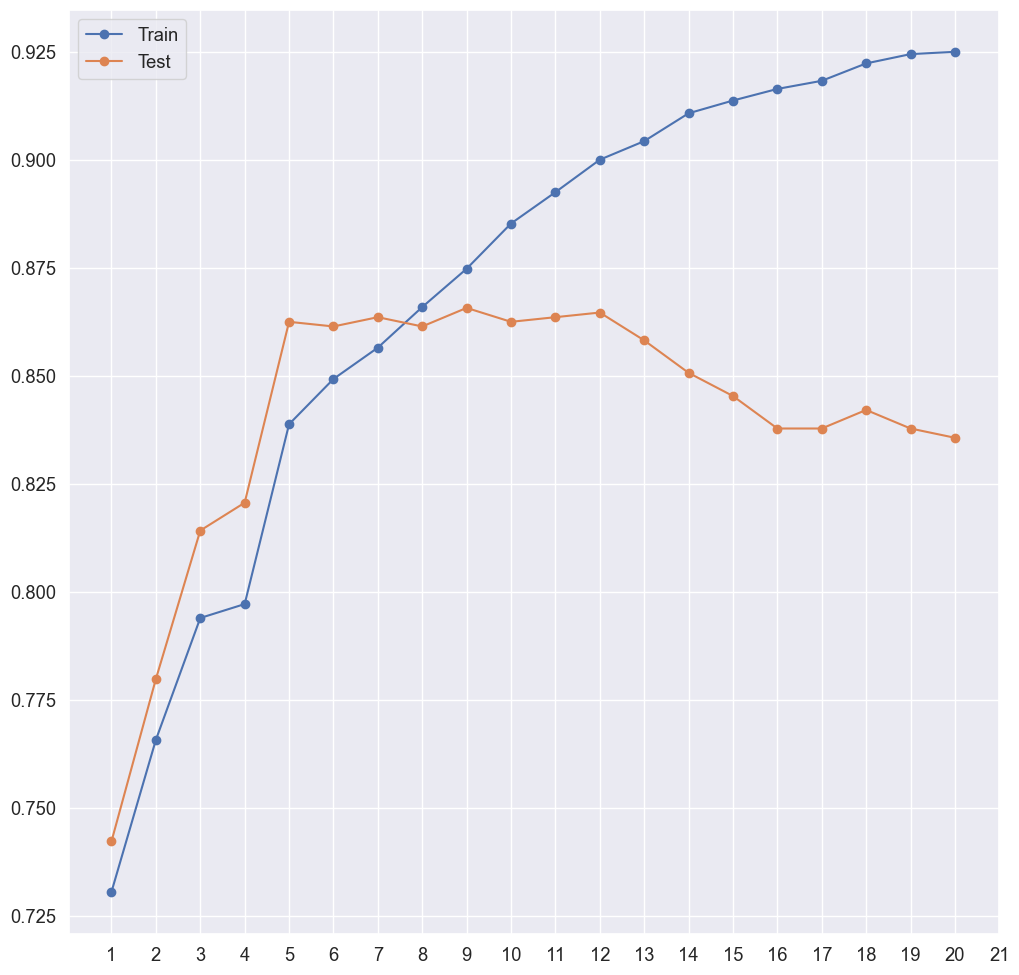

(9, 0.8657357679914071)


In [23]:
values = [i for i in range(1, 21)]
train_scores, test_scores = list(), list()
max_score = 0

# evaluate a decision tree for each depth
for i in values:
    DecisionTree_tune = DecisionTreeClassifier(max_depth=i, random_state=0)
    DecisionTree_tune = DecisionTree_tune.fit(X_train, y_train)
    DecisionTree_tune_score = DecisionTree_tune.score(X_test,y_test)

    # evaluate on the train dataset
    train_ypred = DecisionTree_tune.predict(X_train)
    train_acc = metrics.accuracy_score(y_train, train_ypred)
    train_scores.append(train_acc)

    # evaluate on the test dataset
    test_ypred = DecisionTree_tune.predict(X_test)
    test_acc = metrics.accuracy_score(y_test, test_ypred)
    test_scores.append(test_acc)

    if DecisionTree_tune_score > max_score :
        max_score = DecisionTree_tune_score
        best_max_depth = DecisionTree_tune.max_depth

        t = (i,max_score)

# plot of train and test scores vs tree depth
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(values, train_scores, '-o', label='Train')
ax.plot(values, test_scores, '-o', label='Test')
ax.set_xticks([x for x in range(1,22)])
ax.legend()
plt.show()

print (t)

From the line chart above, a max_depth = 9 gives the best score for both the test and training data set.

In [24]:
# Initialize empty lists to store the performance metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
fpr_scores = []

# Loop through random_state values from 0 to 9
for random_state in range(10):
    # Build the Decision Tree Classifier
    DecisionTree_tune = DecisionTreeClassifier(random_state=random_state, max_depth=9)

    # Fit the model
    DecisionTree_tune.fit(X_train, y_train)

    # Make predictions
    y_pred = DecisionTree_tune.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calculate false positive rate
    fpr, _, _ = roc_curve(y_test, y_pred)
    fpr_score = fpr[1]

    # Append the scores to the respective lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    fpr_scores.append(fpr_score)

    # Print the scores for each random_state
    print(f"Random State: {random_state}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}, FPR: {fpr_score}")

# Calculate average scores
dt_tune_Accuracy=sum(accuracy_scores) / len(accuracy_scores)
dt_tune_Precision=sum(precision_scores) / len(precision_scores)
dt_tune_Recall=sum(recall_scores) / len(recall_scores)
dt_tune_F1_score=sum(f1_scores) / len(f1_scores)
dt_tune_FPR_score = sum(fpr_scores) / len(fpr_scores)

# Print the average scores
print(f"Average Accuracy: {dt_tune_Accuracy}")
print(f"Average Precision: {dt_tune_Precision}")
print(f"Average Recall: {dt_tune_Recall}")
print(f"Average F1 Score: {dt_tune_F1_score}")
print(f"Average FPR Score: {dt_tune_FPR_score}")

Random State: 0, Accuracy: 0.8657357679914071, Precision: 0.8888888888888888, Recall: 0.6978193146417445, F1 Score: 0.781849912739965, FPR: 0.04590163934426229
Random State: 1, Accuracy: 0.8657357679914071, Precision: 0.8888888888888888, Recall: 0.6978193146417445, F1 Score: 0.781849912739965, FPR: 0.04590163934426229
Random State: 2, Accuracy: 0.8657357679914071, Precision: 0.8888888888888888, Recall: 0.6978193146417445, F1 Score: 0.781849912739965, FPR: 0.04590163934426229
Random State: 3, Accuracy: 0.8657357679914071, Precision: 0.8888888888888888, Recall: 0.6978193146417445, F1 Score: 0.781849912739965, FPR: 0.04590163934426229
Random State: 4, Accuracy: 0.8657357679914071, Precision: 0.8888888888888888, Recall: 0.6978193146417445, F1 Score: 0.781849912739965, FPR: 0.04590163934426229
Random State: 5, Accuracy: 0.8668098818474759, Precision: 0.8893280632411067, Recall: 0.7009345794392523, F1 Score: 0.7839721254355401, FPR: 0.04590163934426229
Random State: 6, Accuracy: 0.8668098818

<AxesSubplot:>

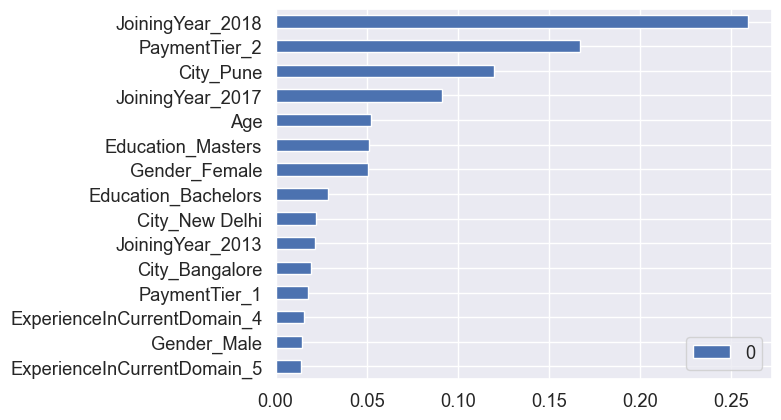

In [25]:
# Feature importance calculation
fi_dt = pd.DataFrame(DecisionTree_tune.feature_importances_)
fi_dt.index = DecisionTree_tune.feature_names_in_
fi_dt = fi_dt.sort_values(by=0)
fi_dt.tail(15).plot.barh()

In [26]:
# Print the feature scores
feature_scores = pd.Series(DecisionTree_tune.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_scores

JoiningYear_2018               0.259127
PaymentTier_2                  0.167168
City_Pune                      0.119928
JoiningYear_2017               0.091073
Age                            0.052456
Education_Masters              0.051390
Gender_Female                  0.050695
Education_Bachelors            0.028871
City_New Delhi                 0.022186
JoiningYear_2013               0.021700
City_Bangalore                 0.019680
PaymentTier_1                  0.017736
ExperienceInCurrentDomain_4    0.015330
Gender_Male                    0.014273
ExperienceInCurrentDomain_5    0.013975
ExperienceInCurrentDomain_2    0.012101
EverBenched_Yes                0.011363
EverBenched_No                 0.005382
JoiningYear_2015               0.004672
ExperienceInCurrentDomain_0    0.004255
ExperienceInCurrentDomain_1    0.003800
JoiningYear_2014               0.003652
ExperienceInCurrentDomain_3    0.002843
ExperienceInCurrentDomain_7    0.002040
PaymentTier_3                  0.001990


### 2. LightGBM (Light Gradient Boosting Machine)

Without hyperparameter tuning

In [27]:
# Build the classifier
lgbm_clf = lgbm.LGBMClassifier(random_state = 42)

# Fitting the Model
lgbm_clf.fit(X_train, y_train)

# Predict the loan_status
simple_lgbm_pred = lgbm_clf.predict(X_test)

# Evaluate the model
simple_lgbm_Accuracy, simple_lgbm_Precision, simple_lgbm_Recall, simple_lgbm_F1_score, simple_lgbm_FPR = model_performance(y_test, simple_lgbm_pred)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1279, number of negative: 2443
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 73
[LightGBM] [Info] Number of data points in the train set: 3722, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.343632 -> initscore=-0.647148
[LightGBM] [Info] Start training from score -0.647148
Accuracy :0.8711063372717508
Precision :0.8910505836575876
Recall :0.7133956386292835
F1_score :0.7923875432525952
FPR :0.04590163934426229


With hyperparameter tuning

In [ ]:
# Set the parameters for grid search
param_grid_lgbm = {
    'n_estimators': [100, 500, 1000, 2000],
    'learning_rate': [0.001, 0.01, 0.1, 0.3],
    'max_depth': [-1, 5, 10, 15],
    'num_leaves': [31, 127, 255, 511],
    'min_child_samples': [5, 20, 50, 100],
}

# Create a based model
lgbm_gs_clf = lgbm.LGBMClassifier(random_state=42)

# Instantiate the grid search model
lgbm_gs = GridSearchCV(estimator = lgbm_gs_clf,
             param_grid = param_grid_lgbm,
             cv=3,
             scoring='accuracy',
             n_jobs=-1
)

# Fit the grid search to the data
lgbm_gs.fit(X_train, y_train)

# Find the best hyperparameters and corresponding model
best_params_lgbm = lgbm_gs.best_params_
best_model_lgbm = lgbm_gs.best_estimator_

# Print the best hyperparameters
print("Best parameters for lgbm", best_params_lgbm)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1279, number of negative: 2443
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 3722, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.343632 -> initscore=-0.647148
[LightGBM] [Info] Start training from score -0.647148
Best parameters for lgbm {'learning_rate': 0.001, 'max_depth': -1, 'min_child_samples': 5, 'n_estimators': 2000, 'num_leaves': 31}


In [29]:
# Initialize empty lists to store the performance metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
fpr_scores = []

# Loop through random_state values from 0 to 9
for random_state in range(10):
    # Build the classifier
    best_model_lgbm = lgbm.LGBMClassifier(seed=random_state,
                                     learning_rate=0.001,
                                     max_depth=-1,
                                     min_child_samples=5,
                                     n_estimators=2000,
                                     num_leaves=31)

    # Fit the model
    best_model_lgbm.fit(X_train, y_train)

    # Make predictions
    lgbm_pred = best_model_lgbm.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, lgbm_pred)
    precision = precision_score(y_test, lgbm_pred)
    recall = recall_score(y_test, lgbm_pred)
    f1 = f1_score(y_test, lgbm_pred)

    # Calculate false positive rate
    fpr, _, _ = roc_curve(y_test, lgbm_pred)
    fpr_score = fpr[1]

    # Append the scores to the respective lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    fpr_scores.append(fpr_score)

    # Print the scores for each random_state
    print(f"Random State: {random_state}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}, FPR: {fpr_score}")

# Calculate average scores
lgbm_gs_Accuracy = sum(accuracy_scores) / len(accuracy_scores)
lgbm_gs_Precision = sum(precision_scores) / len(precision_scores)
lgbm_gs_Recall = sum(recall_scores) / len(recall_scores)
lgbm_gs_F1_score = sum(f1_scores) / len(f1_scores)
lgbm_gs_FPR_score = sum(fpr_scores) / len(fpr_scores)

# Print the average scores
print(f"Average Accuracy: {lgbm_gs_Accuracy}")
print(f"Average Precision: {lgbm_gs_Precision}")
print(f"Average Recall: {lgbm_gs_Recall}")
print(f"Average F1 Score: {lgbm_gs_F1_score}")
print(f"Average FPR Score: {lgbm_gs_FPR_score}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1279, number of negative: 2443
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 3722, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.343632 -> initscore=-0.647148
[LightGBM] [Info] Start training from score -0.647148
Random State: 0, Accuracy: 0.878625134264232, Precision: 0.9333333333333333, Recall: 0.6978193146417445, F1 Score: 0.7985739750445633, FPR: 0.02622950819672131
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1279, number of negative: 2443
[LightGBM] [Info] Auto-choosing row-wise multi-threading, 

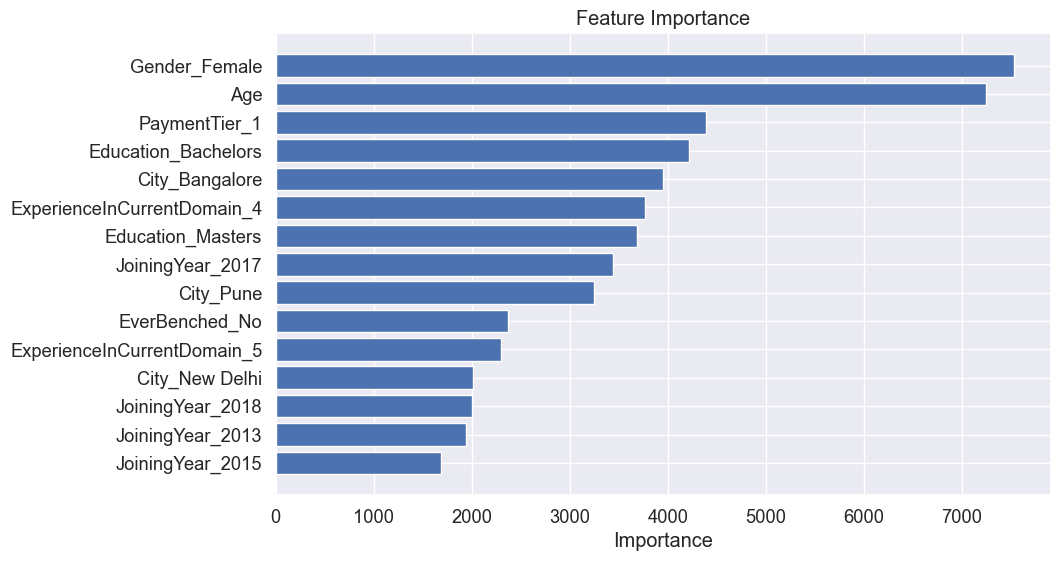

In [30]:
# Get feature importances
importances = best_model_lgbm.feature_importances_

# Get feature names from your data
feature_names = X_train.columns

# Create arrays from feature importance and feature names
feature_imports = pd.DataFrame(data={'Feature': feature_names, 'Importance': importances})

# Sort by the absolute value of the importance of the feature
feature_imports = feature_imports.sort_values(by='Importance', ascending=False)

# Set the size of the figure
plt.figure(figsize=(10, 6))

# Create a bar chart
plt.barh(y=feature_imports['Feature'].head(15), width=feature_imports['Importance'].head(15))

# Invert the y-axis so the feature with the highest importance is on top
plt.gca().invert_yaxis()

# Set labels
plt.xlabel('Importance')
plt.title('Feature Importance')

# Show the plot
plt.show()

### 3. Bagging

Without hyperparameter tuning

In [31]:
# Build the classifier
bc = BaggingClassifier(random_state = 0)

# Fitting the Model
bc.fit(X_train, y_train)

# Predict leave or not
bc_pred = bc.predict(X_test)

# Evaluate the model
bc_Accuracy, bc_Precision, bc_Recall, bc_F1_score, bc_FPR =  model_performance(y_test, bc_pred)

Accuracy :0.8442534908700322
Precision :0.803448275862069
Recall :0.7258566978193146
F1_score :0.7626841243862519
FPR :0.09344262295081968


With hyperparameter tuning

In [52]:
# Set the parameters for grid search
param_grid_bc = {
    'base_estimator': [DecisionTreeClassifier(max_depth=5), DecisionTreeClassifier(max_depth=7), DecisionTreeClassifier(max_depth=9)],
    'n_estimators': [1000, 1500, 2000],
    'max_samples': [0.5, 0.7, 0.9],
    'max_features': [0.5, 0.7, 0.9]
}

# Instantiate the base model
base_model = DecisionTreeClassifier(random_state=42)

# Instantiate the grid search model
bc_gs = GridSearchCV(estimator=BaggingClassifier(base_estimator=base_model, random_state=42),
                     param_grid=param_grid_bc,
                     cv=3,
                     n_jobs=-1,
                     verbose=2)

# Fit the grid search to the data
bc_gs.fit(X_train, y_train)

# Find the best hyperparameters
best_params_bc = bc_gs.best_params_

# Print the best hyperparameters
print("Best parameters for Bagging Classifier:", best_params_bc)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters for Bagging Classifier: {'base_estimator': DecisionTreeClassifier(max_depth=7), 'max_features': 0.9, 'max_samples': 0.5, 'n_estimators': 1000}


In [33]:
# Initialize empty lists to store the performance metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
fpr_scores = []

# Loop through random_state values from 0 to 9
for random_state in range(10):
    # Build the classifier
    best_model_bc = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=7),
                                      n_estimators=1000,
                                      max_samples=0.5,
                                      max_features=0.9,
                                      random_state=random_state)

    # Fit the model
    best_model_bc.fit(X_train, y_train)

    # Make predictions
    y_pred = best_model_bc.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calculate false positive rate
    fpr, _, _ = roc_curve(y_test, y_pred)
    fpr_score = fpr[1]

    # Append the scores to the respective lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    fpr_scores.append(fpr_score)

    # Print the scores for each random_state
    print(f"Random State: {random_state}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}, FPR: {fpr_score}")

# Calculate average scores
bc_gs_Accuracy = sum(accuracy_scores) / len(accuracy_scores)
bc_gs_Precision = sum(precision_scores) / len(precision_scores)
bc_gs_Recall = sum(recall_scores) / len(recall_scores)
bc_gs_F1_score = sum(f1_scores) / len(f1_scores)
bc_gs_FPR_score = sum(fpr_scores) / len(fpr_scores)

# Print the average scores
print(f"Average Accuracy: {bc_gs_Accuracy}")
print(f"Average Precision: {bc_gs_Precision}")
print(f"Average Recall: {bc_gs_Recall}")
print(f"Average F1 Score: {bc_gs_F1_score}")
print(f"Average FPR Score: {bc_gs_FPR_score}")

Random State: 0, Accuracy: 0.8807733619763695, Precision: 0.92, Recall: 0.7165109034267912, F1 Score: 0.8056042031523643, FPR: 0.03278688524590164
Random State: 1, Accuracy: 0.8796992481203008, Precision: 0.9196787148594378, Recall: 0.7133956386292835, F1 Score: 0.8035087719298246, FPR: 0.03278688524590164
Random State: 2, Accuracy: 0.878625134264232, Precision: 0.916, Recall: 0.7133956386292835, F1 Score: 0.8021015761821366, FPR: 0.03442622950819672
Random State: 3, Accuracy: 0.878625134264232, Precision: 0.916, Recall: 0.7133956386292835, F1 Score: 0.8021015761821366, FPR: 0.03442622950819672
Random State: 4, Accuracy: 0.8796992481203008, Precision: 0.9163346613545816, Recall: 0.7165109034267912, F1 Score: 0.8041958041958042, FPR: 0.03442622950819672
Random State: 5, Accuracy: 0.878625134264232, Precision: 0.916, Recall: 0.7133956386292835, F1 Score: 0.8021015761821366, FPR: 0.03442622950819672
Random State: 6, Accuracy: 0.878625134264232, Precision: 0.916, Recall: 0.7133956386292835

### 4. Random Forest

Without hyperparameter tuning

In [34]:
# Build the classifier
randomForest = RandomForestClassifier(random_state=42)

# Fitting the Model
randomForest.fit(X_train, y_train)

# Predict leave or not
rf_pred = randomForest.predict(X_test)

# Evaluate the model
rf_Accuracy, rf_Precision, rf_Recall, rf_F1_score, rf_FPR = model_performance(y_test, rf_pred)

Accuracy :0.8378088077336198
Precision :0.791095890410959
Recall :0.719626168224299
F1_score :0.7536704730831975
FPR :0.1


With hyperparameter tuning

In [ ]:
# Set the parameters for grid search
param_grid_rf = {'bootstrap': [True],
                 'max_depth': [5, 10, 15],
                 'min_samples_leaf': [1, 3, 5],
                 'min_samples_split': [3, 4, 5],
                 'n_estimators': [1000, 1500, 2000]}

# Create a based model
rf = RandomForestClassifier(random_state = 42)

# Instantiate the grid search model
rf_gs = GridSearchCV(estimator = rf,
            param_grid = param_grid_rf,
            cv = 3,
            n_jobs = -1,
            verbose = 2
)

# Fit the grid search to the data
rf_gs.fit(X_train, y_train)

# Find the best hyperparameters
best_params_rf = rf_gs.best_params_

# Print the best hyperparameters
print("Best parameters for random forest", best_params_rf)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters for random forest {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 2000}


In [35]:
# Initialize empty lists to store the performance metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
fpr_scores = []

# Loop through random_state values from 0 to 9
for random_state in range(10):
    # Build the classifier
    best_model_rf = RandomForestClassifier(
                      bootstrap=True,
                      max_depth=10,
                      min_samples_leaf=3,
                      min_samples_split=3,
                      n_estimators=2000,
                      random_state=random_state
                      )

    # Fit the model
    best_model_rf.fit(X_train, y_train)

    # Make predictions
    rf_gs_pred = best_model_rf.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, rf_gs_pred)
    precision = precision_score(y_test, rf_gs_pred)
    recall = recall_score(y_test, rf_gs_pred)
    f1 = f1_score(y_test, rf_gs_pred)

    # Calculate false positive rate
    fpr, _, _ = roc_curve(y_test, rf_gs_pred)
    fpr_score = fpr[1]

    # Append the scores to the respective lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    fpr_scores.append(fpr_score)

    # Print the scores for each random_state
    print(f"Random State: {random_state}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}, FPR: {fpr_score}")

# Calculate average scores
rf_gs_Accuracy = sum(accuracy_scores) / len(accuracy_scores)
rf_gs_Precision = sum(precision_scores) / len(precision_scores)
rf_gs_Recall = sum(recall_scores) / len(recall_scores)
rf_gs_F1_score = sum(f1_scores) / len(f1_scores)
rf_gs_FPR_score = sum(fpr_scores) / len(fpr_scores)

# Print the average scores
print(f"Average Accuracy: {rf_gs_Accuracy}")
print(f"Average Precision: {rf_gs_Precision}")
print(f"Average Recall: {rf_gs_Recall}")
print(f"Average F1 Score: {rf_gs_F1_score}")
print(f"Average FPR Score: {rf_gs_FPR_score}")

Random State: 0, Accuracy: 0.874328678839957, Precision: 0.9322033898305084, Recall: 0.6853582554517134, F1 Score: 0.7899461400359067, FPR: 0.02622950819672131
Random State: 1, Accuracy: 0.8775510204081632, Precision: 0.9367088607594937, Recall: 0.6915887850467289, F1 Score: 0.7956989247311828, FPR: 0.02459016393442623
Random State: 2, Accuracy: 0.8754027926960258, Precision: 0.9361702127659575, Recall: 0.6853582554517134, F1 Score: 0.7913669064748201, FPR: 0.02459016393442623
Random State: 3, Accuracy: 0.8754027926960258, Precision: 0.9399141630901288, Recall: 0.6822429906542056, F1 Score: 0.7906137184115524, FPR: 0.022950819672131147
Random State: 4, Accuracy: 0.8754027926960258, Precision: 0.9324894514767933, Recall: 0.6884735202492211, F1 Score: 0.7921146953405018, FPR: 0.02622950819672131
Random State: 5, Accuracy: 0.8764769065520945, Precision: 0.9291666666666667, Recall: 0.6947040498442367, F1 Score: 0.7950089126559715, FPR: 0.027868852459016394
Random State: 6, Accuracy: 0.8786

In [36]:
# Print the feature scores
feature_scores = pd.Series(best_model_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_scores

JoiningYear_2018               0.270520
City_Pune                      0.085717
PaymentTier_2                  0.071865
Education_Masters              0.060995
PaymentTier_3                  0.060951
Gender_Female                  0.056108
Gender_Male                    0.055867
Age                            0.051694
Education_Bachelors            0.050159
JoiningYear_2017               0.038156
City_New Delhi                 0.032967
City_Bangalore                 0.030533
JoiningYear_2013               0.013895
JoiningYear_2015               0.013536
ExperienceInCurrentDomain_2    0.012084
ExperienceInCurrentDomain_4    0.011462
PaymentTier_1                  0.010691
JoiningYear_2014               0.009182
Education_PHD                  0.008719
EverBenched_Yes                0.008238
EverBenched_No                 0.008163
ExperienceInCurrentDomain_3    0.007368
JoiningYear_2012               0.007255
JoiningYear_2016               0.007208
ExperienceInCurrentDomain_5    0.007148


<AxesSubplot:>

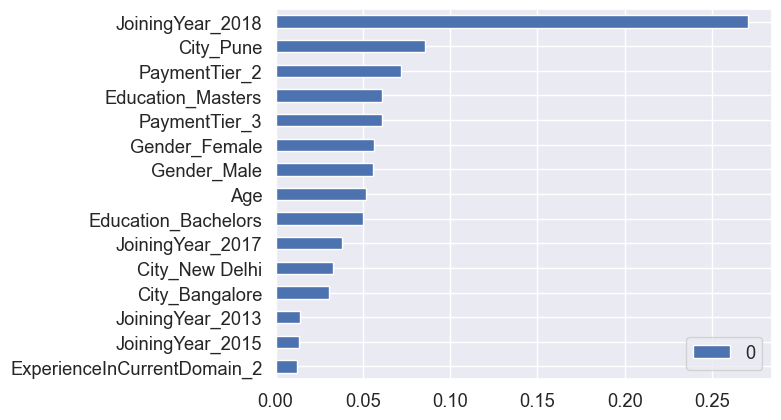

In [37]:
# Feature importance calculation
fi_rf = pd.DataFrame(best_model_rf.feature_importances_)
fi_rf.index = best_model_rf.feature_names_in_
fi_rf = fi_rf.sort_values(by=0)
fi_rf.tail(15).plot.barh()

### E1. XG Boost (Excluded in report)

Without hyperparameter tuning

In [39]:
# Build the classifier
XGB = XGBClassifier(random_state=0)

# Fitting the Model
XGB.fit(X_train, y_train)

# Predict the loan_status
XGB_pred = XGB.predict(X_test)

# Evaluate the model
XGB_Accuracy, XGB_Precision, XGB_Recall, XGB_F1_score, XGB_FPR = model_performance(y_test, XGB_pred)

Accuracy :0.8635875402792696
Precision :0.8540145985401459
Recall :0.7289719626168224
F1_score :0.7865546218487394
FPR :0.06557377049180328


With hyperparameter tuning

In [ ]:
param_grid_XGB = {
    'max_depth': [3, 6, 9, 12],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300, 500, 1000],
    'gamma': [0, 0.1, 0.2],
    'subsample': [1.0],
    'colsample_bytree': [1.0]
}

# Create an XGBoost classifier
xgb = XGBClassifier(random_state=0)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=xgb,
                           param_grid=param_grid_XGB,
                           cv=3,
                           scoring='accuracy',
                           n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and corresponding model
best_params_XGB = grid_search.best_params_
best_model_XGB = grid_search.best_estimator_

# Print the best hyperparameters
print("Best parameters for XGBoost:", best_params_XGB)

Best parameters for XGBoost: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 500, 'subsample': 1.0}


In [40]:
# Build the classifier
best_model_XGB = XGBClassifier(colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth= 6, n_estimators =500, subsample = 1.0, random_state=0)

# Fitting the Model
best_model_XGB.fit(X_train, y_train)

# Predict the loan_status
XGB_gs_pred = best_model_XGB.predict(X_test)

# Evaluate the model
XGB_gs_Accuracy, XGB_gs_Precision, XGB_gs_Recall, XGB_gs_F1_score, XGB_gs_FPR = model_performance(y_test, XGB_gs_pred)

Accuracy :0.8775510204081632
Precision :0.9058823529411765
Recall :0.719626168224299
F1_score :0.8020833333333333
FPR :0.03934426229508197


<AxesSubplot:>

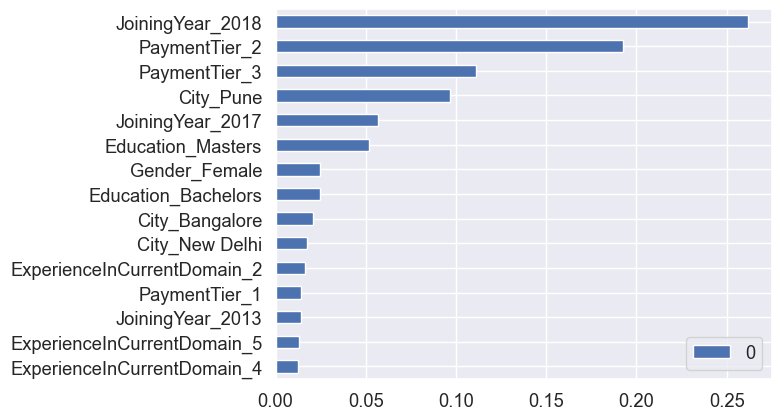

In [41]:
# Feature importance calculation
fi_XGB = pd.DataFrame(best_model_XGB.feature_importances_)
fi_XGB.index = best_model_XGB.feature_names_in_
fi_XGB = fi_XGB.sort_values(by=0)
fi_XGB.tail(15).plot.barh()

### E2. K-NN Algorithm (Excluded in report)

Without hyperparameter tuning

In [42]:
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Build the classifier
KNN = KNeighborsClassifier()

# Fitting the Model
KNN.fit(X_train, y_train)

# Predict the loan_status
KNN_pred = KNN.predict(X_test)

# Evaluate the model
KNN_Accuracy, KNN_Precision, KNN_Recall, KNN_F1_score, KNN_FPR = model_performance(y_test, KNN_pred)

Accuracy :0.8152524167561761
Precision :0.8040816326530612
Recall :0.6137071651090342
F1_score :0.6961130742049471
FPR :0.07868852459016394


With hyperparameter tuning

In [50]:
# Set the parameters for grid search
param_grid_KNN = {
    'n_neighbors': range(5, 30, 5),
    'p': [1,2],
    'weights': ['uniform', 'distance']
}

# Create a based model
KNN_gs = KNeighborsClassifier()

# Instantiate the grid search model
KNN_gs = GridSearchCV(estimator = KNN_gs,
            param_grid = param_grid_KNN,
            cv = 3,
            n_jobs = 5,
)

# Fit the grid search to the data
KNN_gs.fit(X_train, y_train)

# Find the best hyperparameters and corresponding model
best_params_KNN = KNN_gs.best_params_
best_model_KNN = KNN_gs.best_estimator_

# Print the best hyperparameters
print("Best parameters for KNN", best_params_KNN)

Best parameters for KNN {'n_neighbors': 15, 'p': 1, 'weights': 'distance'}


In [45]:
# Build the classifier
best_model_KNN = KNeighborsClassifier(n_neighbors=15, p=1, weights='distance')

# Fitting the Model
best_model_KNN.fit(X_train, y_train)

# Predict the loan_status
KNN_gs_pred = best_model_KNN.predict(X_test)

# Evaluate the model
KNN_gs_Accuracy, KNN_gs_Precision, KNN_gs_Recall, KNN_gs_F1_score, KNN_gs_FPR = model_performance(y_test, KNN_gs_pred)

Accuracy :0.8259935553168636
Precision :0.8382978723404255
Recall :0.6137071651090342
F1_score :0.7086330935251799
FPR :0.06229508196721312


## Section: Model Evaluation
In this section, we will summarize the model performance in the previous section and plot the AUC-ROC Curve.

**Person-in-charge:** Lui Chak Sum, Li Shengwei

In [46]:
# Create a list of model names
models = ['Decision Tree', 'Light Gradient Boosting', 'Bagging', 'Random Forest'] # Exclude: 'XGBoost', 'K-NN Algorithm'

# Create a dictionary to store the performance measures
performance = {
    'Model': models,
    'Accuracy': [dt_tune_Accuracy, lgbm_gs_Accuracy, bc_gs_Accuracy, rf_gs_Accuracy], #XGB_gs_Accuracy, KNN_gs_Accuracy
    'Precision': [dt_tune_Precision, lgbm_gs_Precision, bc_gs_Precision, rf_gs_Precision], #XGB_gs_Precision, KNN_gs_Precision
    'Recall': [dt_tune_Recall, lgbm_gs_Recall, bc_gs_Recall, rf_gs_Recall], #XGB_gs_Recall, KNN_gs_Recall
    'F1_score': [dt_tune_F1_score, lgbm_gs_F1_score, bc_gs_F1_score, rf_gs_F1_score], #XGB_gs_F1_score, KNN_gs_F1_score
    'FPR':[dt_tune_FPR_score, lgbm_gs_FPR_score, bc_gs_FPR_score, rf_gs_FPR_score] #XGB_gs_FPR, KNN_gs_FPR
}

# Create a dataframe from the performance dictionary
performance_df = pd.DataFrame(performance)

# Print the dataframe
print(performance_df)

                     Model  Accuracy  Precision    Recall  F1_score       FPR
0            Decision Tree  0.866165   0.889065  0.699065  0.782699  0.045902
1  Light Gradient Boosting  0.878625   0.933333  0.697819  0.798574  0.026230
2                  Bagging  0.878947   0.917104  0.713396  0.802521  0.033934
3            Random Forest  0.876047   0.935986  0.687539  0.792739  0.024754


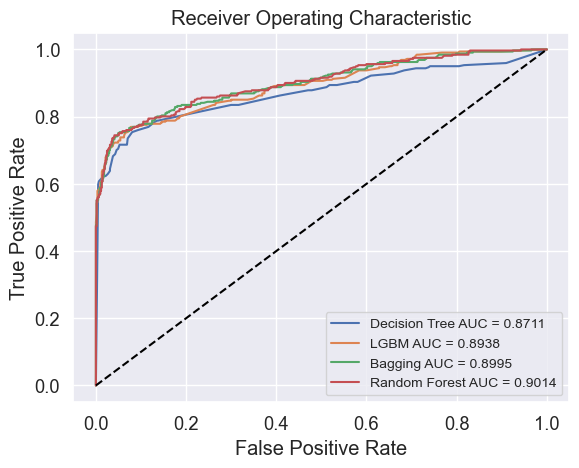

In [49]:
# Get predicted probabilities for the positive class from each model
dt_tune_prob = DecisionTree_tune.predict_proba(X_test)[:,1]
lgbm_gs_prob = best_model_lgbm.predict_proba(X_test)[:,1]
bc_gs_prob = best_model_bc.predict_proba(X_test)[:,1]
rf_gs_prob = best_model_rf.predict_proba(X_test)[:,1]
#XGB_gs_prob = best_model_XGB.predict_proba(X_test)[:,1]
#KNN_gs_prob = best_model_KNN.predict_proba(X_test)[:,1]

# Get the fpr, tpr, thresholds for each model
dt_fpr, dt_tpr, dt_thresholds = metrics.roc_curve(y_test, dt_tune_prob)
lgbm_fpr, lgbm_tpr, lgbm_thresholds = metrics.roc_curve(y_test, lgbm_gs_prob)
bc_fpr, bc_tpr, bc_thresholds = metrics.roc_curve(y_test, bc_gs_prob)
rf_fpr, rf_tpr, rf_thresholds = metrics.roc_curve(y_test, rf_gs_prob)
#XGB_fpr, XGB_tpr, XGB_thresholds = metrics.roc_curve(y_test, XGB_gs_prob)
#KNN_fpr, KNN_tpr, KNN_thresholds = metrics.roc_curve(y_test, KNN_gs_prob)
fpr = [dt_fpr, lgbm_fpr, bc_fpr, rf_fpr] #XGB_fpr, KNN_fpr
tpr = [dt_tpr, lgbm_tpr, bc_tpr, rf_tpr] #XGB_tpr, KNN_tpr

# Calulate the AUC
dt_auc = metrics.roc_auc_score(y_test, dt_tune_prob)
lgbm_auc = metrics.roc_auc_score(y_test, lgbm_gs_prob)
bc_auc = metrics.roc_auc_score(y_test, bc_gs_prob)
rf_auc = metrics.roc_auc_score(y_test, rf_gs_prob)
#XGB_auc = metrics.roc_auc_score(y_test2, XGB_gs_prob)
#KNN_auc = metrics.roc_auc_score(y_test1, KNN_gs_prob)
auc = [dt_auc, lgbm_auc, bc_auc, rf_auc] #XGB_auc, KNN_auc

# create ROC curve
model_names = ["Decision Tree", "LGBM", "Bagging", "Random Forest"] #"XGBoost", "KNN"

plt.figure()
for i in range(len(fpr)):
    plt.plot(fpr[i], tpr[i], label=model_names[i] + " AUC = {:.4f}".format(auc[i]))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right', prop={'size': 10})
plt.show()

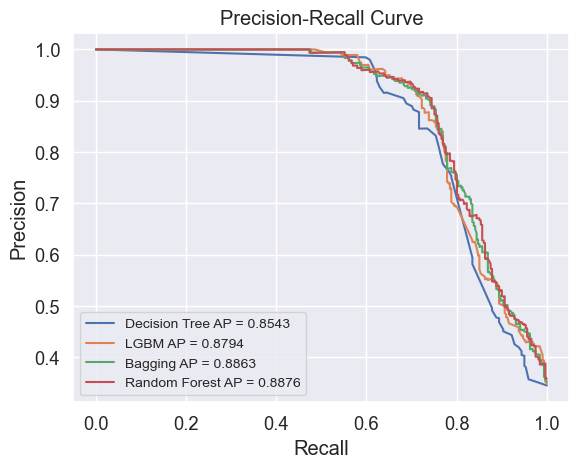

In [48]:
# Get the precision, recall, thresholds for each model
dt_precision, dt_recall, dt_thresholds = metrics.precision_recall_curve(y_test, dt_tune_prob)
lgbm_precision, lgbm_recall, lgbm_thresholds = metrics.precision_recall_curve(y_test, lgbm_gs_prob)
bc_precision, bc_recall, bc_thresholds = metrics.precision_recall_curve(y_test, bc_gs_prob)
rf_precision, rf_recall, rf_thresholds = metrics.precision_recall_curve(y_test, rf_gs_prob)
#XGB_precision, XGB_recall, XGB_thresholds = metrics.precision_recall_curve(y_test, XGB_gs_prob)
#KNN_precision, KNN_recall, KNN_thresholds = metrics.precision_recall_curve(y_test, KNN_gs_prob)
precision = [dt_precision, lgbm_precision, bc_precision, rf_precision] #XGB_precision, KNN_precision
recall = [dt_recall, lgbm_recall, bc_recall, rf_recall] #XGB_recall, KNN_recall

# Calulate the average precision score
dt_avg_precision = metrics.average_precision_score(y_test, dt_tune_prob)
lgbm_avg_precision = metrics.average_precision_score(y_test, lgbm_gs_prob)
bc_avg_precision = metrics.average_precision_score(y_test, bc_gs_prob)
rf_avg_precision = metrics.average_precision_score(y_test, rf_gs_prob)
#XGB_avg_precision = metrics.average_precision_score(y_test, XGB_gs_prob)
#KNN_avg_precision = metrics.average_precision_score(y_test, KNN_gs_prob)
avg_precision = [dt_avg_precision, lgbm_avg_precision, bc_avg_precision, rf_avg_precision] #XGB_avg_precision, KNN_avg_precision

# Create PR curve
model_names = ["Decision Tree", "LGBM", "Bagging", "Random Forest"] #"XGBoost", "KNN"

plt.figure()
for i in range(len(precision)):
    plt.plot(recall[i], precision[i], label=model_names[i] + " AP = {:.4f}".format(avg_precision[i]))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left', prop={'size': 10})
plt.show()